### Imports

In [67]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import glob 
import torch
import torchaudio
import torchaudio.transforms as T

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch import nn

# to play the audio files
from IPython.display import Audio

In [45]:
# Base directory
base_dir = "./archive"

# Lists to store file paths and the third number in the filename
file_paths = []
emotions = []

emotions_dict ={
    "01" : "neutral",
    "02" : "calm",
    "03" : "happy",
    "04" : "sad",
    "05" : "angry",
    "06" : "fear",
    "07" : "disgust",
    "08" : "suprised"
}

# Loop over all Actor_XX folders
for actor_folder in sorted(glob.glob(os.path.join(base_dir, "Actor_*"))):
    # Get all .wav files in this folder
    wav_files = glob.glob(os.path.join(actor_folder, "*.wav"))
    
    for wav_file in wav_files:
        # Append full path to the list
        file_paths.append(wav_file)
        
        # Extract filename (without folder)
        filename = os.path.basename(wav_file)
        
        # Split by '-' and get the third number
        parts = filename.split('-')
        if len(parts) >= 3:
            emotion_number = parts[2]
            emotions.append(emotions_dict[emotion_number])
        else:
            print(f"Warning: unexpected filename format: {filename}")

# Check if both lists are equal in length
print(f"Collected {len(file_paths)} files.")
print(f"Collected {len(emotions)} labels.")
print("Example:", file_paths[200], "->", emotions[200])

Collected 1440 files.
Collected 1440 labels.
Example: ./archive/Actor_04/03-01-07-01-02-02-04.wav -> disgust


### Ploting Functions

In [46]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

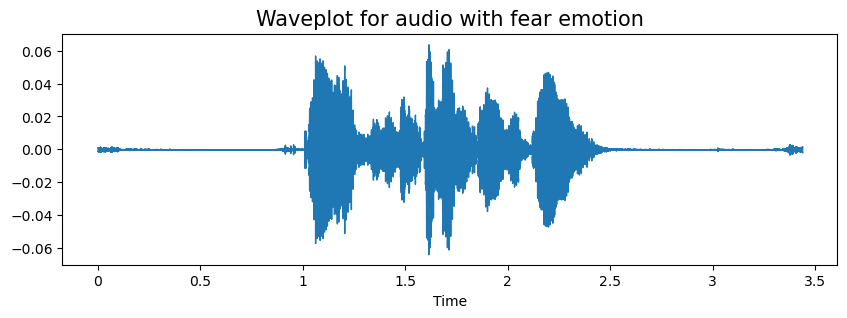

In [47]:
path = "./archive/Actor_01/03-01-06-01-02-01-01.wav"

data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, 'fear')

Audio(path)

### Augmentation 

In [48]:
def noise(waveform, noise_factor=0.05):
    """
    Adds Gaussian noise to a waveform tensor.
    waveform: torch.Tensor (1, num_samples)
    """
    noise = torch.randn_like(waveform)
    augmented = waveform + noise_factor * noise * waveform.abs().max()
    return augmented.clamp(-1.0, 1.0)

def shift(waveform, sampling_rate, n_steps=2):
    """
    Shifts pitch by n_steps semitones without changing duration.
    """
    transform = T.PitchShift(sample_rate=sampling_rate, n_steps=n_steps)
    return transform(waveform)

In [53]:
def extract_melspectrogram(waveform, sampling_rate):
    """
    Computes mean Mel-spectrogram features for a waveform tensor.
    Returns a 1D NumPy array.
    """
    mel_transform = T.MelSpectrogram(
        sample_rate=sampling_rate,
        n_mels=128,
        n_fft=2048,
        hop_length=512
    )
    mel_spec = mel_transform(waveform)                # shape: (1, n_mels, time)
    mel_db = T.AmplitudeToDB()(mel_spec)              # convert to dB scale
    mel_mean = torch.mean(mel_db, dim=-1).squeeze(0)  # average across time
    return mel_mean.detach().numpy()                  # return as NumPy array

def get_feature(path, duration=3, offset=0.5):
    """
    Loads an audio file, extracts features with and without augmentations.
    Returns a 2D NumPy array: [original, pitch-shifted, noise-augmented].
    """
    # Load audio
    data, sr = librosa.load(path)
    waveform = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

    # Optional: trim/pad to duration seconds
    target_len = int(sr * duration)
    start = int(offset * sr)
    end = start + target_len
    waveform = waveform[:, start:end]

    # If shorter, pad with zeros
    if waveform.shape[1] < target_len:
        pad_len = target_len - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_len))

    # No augmentation
    base_features = extract_melspectrogram(waveform, sr)
    result = np.array(base_features)

    # Pitch-shifted
    pitched = shift(waveform, sr, n_steps=2)
    pitched_features = extract_melspectrogram(pitched, sr)
    result = np.vstack((result, pitched_features))

    # Noise-augmented
    noised = noise(waveform, noise_factor=0.05)
    noised_features = extract_melspectrogram(noised, sr)
    result = np.vstack((result, noised_features))

    return result

In [54]:
audio_files_features, corresponding_emotions = [], []

for path, emotion in zip(file_paths, emotions):
    feature = get_feature(path)
    for audio_file in feature:
        audio_files_features.append(audio_file)
        corresponding_emotions.append(emotion)

### Saving

In [55]:
torch.save(
    {
        # "model_state_dict": first_model.state_dict(),
        # "train_losses": first_train_losses,
        # "train_accs": first_train_accs,
        "emotions": corresponding_emotions,
        "audio_files_list": audio_files_features,
    },
    "./saved_lists.ckpt",
)

In [61]:
df = pd.DataFrame(audio_files_features)
df['emotions'] = corresponding_emotions
df.tail()
df.dtypes

0           float32
1           float32
2           float32
3           float32
4           float32
             ...   
124         float32
125         float32
126         float32
127         float32
emotions     object
Length: 129, dtype: object

In [28]:
print(len(audio_files_features[0]))

128


In [57]:
encoder = OneHotEncoder()
encoded_emotions = encoder.fit_transform(np.array(df['emotions'].values).reshape(-1, 1)).toarray()

In [71]:
audio_files_features = df.iloc[: ,:-1].values

x_train, x_temp, y_train, y_temp = train_test_split(audio_files_features, encoded_emotions, test_size=0.3, random_state=42, shuffle=True)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val   = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((3024, 128, 1), (3024, 8), (648, 128, 1), (648, 8), (648, 128, 1), (648, 8))

### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.sequentials(
            nn.Conv1d(1, 64, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),        
            nn.Conv1d(64, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.2)
            nn.Conv1d(32, 16, 3),
            nn.ReLU(),
        )

        

        
        